In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import skimage
import math
from skimage.io import imsave, imread
from skimage.transform import resize
from PIL import Image
from shutil import copyfile
from collections import Counter
from sklearn.metrics import confusion_matrix
import itertools

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.optimizers import SGD, Adadelta, Adam
from keras.applications.xception import Xception
from keras.applications.vgg16 import VGG16

from keras.layers import BatchNormalization
from keras.optimizers import RMSprop

from keras.utils import np_utils

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn import neighbors
from sklearn.svm import SVC

%matplotlib inline

C:\Program Files\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from preprocess import load_dir, preprocess_and_save_images, divide_to_train_end_test

In [3]:
from work_with_keras_nets import shuffle_Xy, create_net_with_name, one_hot, plot_confusion_matrix

In [4]:
import tensorflow as tf
os.environ["CUDA_VISIBLE_DEVICES"] = '0' #use GPU with ID=0
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5 # maximun alloc gpu50% of MEM
config.gpu_options.allow_growth = True #allocate dynamically
sess = tf.Session(config = config)

In [5]:
# fix random seed for reproducibility
np.random.seed(42)

In [6]:
def load_dir_with_files_divided_to_5(directory, target_names):
    X_lt = []
    X_rt = []
    X_lb = []
    X_rb = []
    X_ct = []
    
    y_lt = []
    y_rt = []
    y_lb = []
    y_rb = []
    y_ct = []    
    
    for root, dirs, files in os.walk(directory):
        for name in files:
            file_path = os.path.join(root, name)
            target_name_dir_path, corner_name = os.path.split(root)
            _, target_name = os.path.split(target_name_dir_path)
            
            cur_X = imread(file_path)
            
            # сравниваем считанный target_name с названиями из target_names
            cur_y = target_names.index(target_name)
            
            if corner_name == "left_top":
                X_lt.append(cur_X)
                y_lt.append(cur_y)
            if corner_name == "right_top":
                X_rt.append(cur_X)
                y_rt.append(cur_y)
            if corner_name == "left_bottom":
                X_lb.append(cur_X)
                y_lb.append(cur_y)
            if corner_name == "right_bottom":
                X_rb.append(cur_X)
                y_rb.append(cur_y)
            if corner_name == "center":
                X_ct.append(cur_X)
                y_ct.append(cur_y)
                
    return np.array(X_lt), np.array(y_lt), np.array(X_rt), np.array(y_rt), np.array(X_lb), np.array(y_lb), \
np.array(X_rb), np.array(y_rb), np.array(X_ct), np.array(y_ct)
    

In [7]:
%%time
X_lt_FNS128, y_lt_FNS128, X_rt_FNS128, y_rt_FNS128, X_lb_FNS128, y_lb_FNS128, X_rb_FNS128, y_rb_FNS128, X_ct_FNS128, y_ct_FNS128 \
= load_dir_with_files_divided_to_5("D:/svruchtel/PREPROCESSED_DATA/France_New_ByShape_128_3dim",
                                ["A4", "Slip", "Ticket"])

Wall time: 31.1 s


In [85]:
# so, let's try another one - there will be neuron net for each part

In [8]:
def print_confusion_matrix(model, X_train, y_train, X_test, y_test, categories_count):
    ### CONFUSION MATRIX 
    
    y_pred_train = model.predict(X_train)
    cnf_matrix = confusion_matrix(one_hot(y_train, categories_count).argmax(axis=1), (y_pred_train.round()).argmax(axis=1))

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=range(categories_count),
                      title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=range(categories_count), normalize=True,
                      title='Normalized confusion matrix')

    plt.show()

    y_pred_test = model.predict(X_test)
    cnf_matrix = confusion_matrix(one_hot(y_test, categories_count).argmax(axis=1), (y_pred_test.round()).argmax(axis=1))

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=range(categories_count),
                      title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=range(categories_count), normalize=True,
                      title='Normalized confusion matrix')

    plt.show()

In [9]:
### Xception, with retrain

def run_Xception_with_retrain_on_dataset(X_train, y_train, X_test, y_test, categories_count, patience):
    
    model_app = Xception(input_shape=X_train[0].shape, include_top=False)
    model_app.trainable = True
    
    model = Sequential()
    model.add(model_app)
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(categories_count, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    
    callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=patience, verbose=0, mode='auto')
    history_callback = model.fit(X_train, one_hot(y_train, categories_count), 
                                 validation_data=(X_test, one_hot(y_test, categories_count)),
                                 epochs=300, batch_size=10, callbacks=[callback])

    test_scores = model.evaluate(X_test, one_hot(y_test, categories_count), verbose=0)
    
    print_confusion_matrix(model, X_train, y_train, X_test, y_test, categories_count)
    
    return model, history_callback, test_scores

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 4, 4, 2048)        20861480  
_________________________________________________________________
flatten_2 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 98307     
Total params: 20,959,787
Trainable params: 20,905,259
Non-trainable params: 54,528
_________________________________________________________________
None
Train on 3234 samples, validate on 362 samples
Epoch 1/300
3234/3234 [==============================] - 108s 34ms/step - loss: 0.3703 - acc: 0.8831 - val_loss: 0.8724 - val_acc: 0.7901
Epoch 2/300
3234/3234 [==============================] - 96s 30ms/s

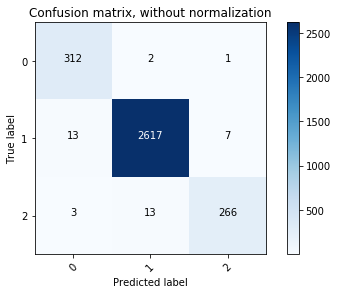

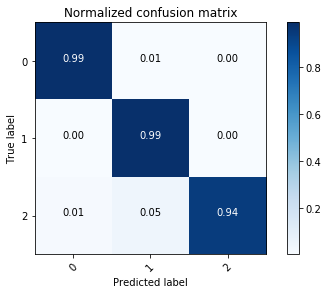

Confusion matrix, without normalization
[[ 23   7   6]
 [ 13 281   0]
 [  4  10  18]]
Normalized confusion matrix
[[0.63888889 0.19444444 0.16666667]
 [0.04421769 0.95578231 0.        ]
 [0.125      0.3125     0.5625    ]]


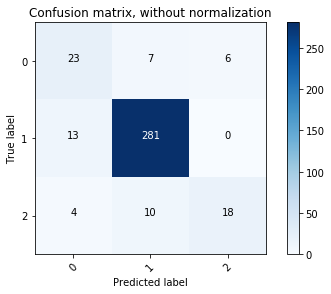

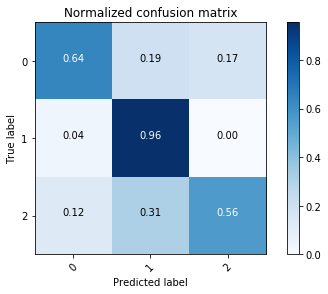

Wall time: 45min 25s


In [11]:
%%time
X_ct_train, y_ct_train, X_ct_test, y_ct_test = divide_to_train_end_test(X_ct_FNS128, y_ct_FNS128, num_categories=3)


model_ct, history_ct, test_scores_ct = run_Xception_with_retrain_on_dataset(X_ct_train, y_ct_train,
                                                                           X_ct_test, y_ct_test,
                                                                           categories_count=3,
                                                                           patience=7)

In [12]:
print("center result accuracy:", test_scores_ct[1])

center result accuracy: 0.8922651933701657


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 4, 4, 2048)        20861480  
_________________________________________________________________
flatten_3 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 98307     
Total params: 20,959,787
Trainable params: 20,905,259
Non-trainable params: 54,528
_________________________________________________________________
None
Train on 3234 samples, validate on 362 samples
Epoch 1/300
3234/3234 [==============================] - 109s 34ms/step - loss: 0.5480 - acc: 0.8352 - val_loss: 0.6547 - val_acc: 0.7320
Epoch 2/300
3234/3234 [==============================] - 95s 30ms/s

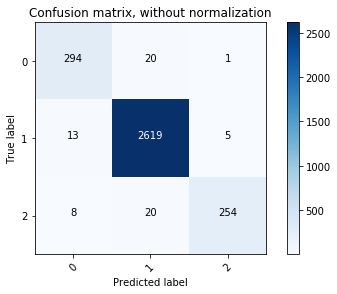

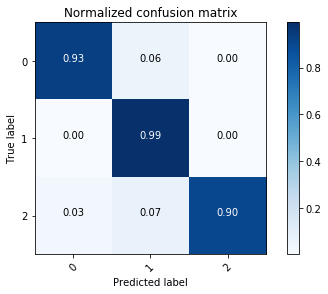

Confusion matrix, without normalization
[[ 26   5   5]
 [ 12 280   2]
 [  2   6  24]]
Normalized confusion matrix
[[0.72222222 0.13888889 0.13888889]
 [0.04081633 0.95238095 0.00680272]
 [0.0625     0.1875     0.75      ]]


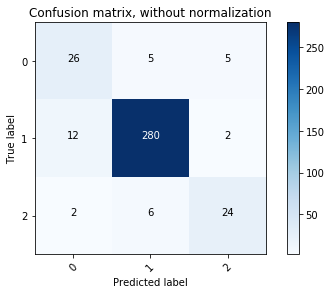

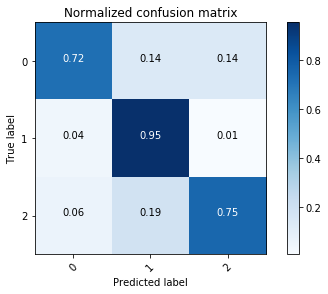

Wall time: 28min 33s


In [13]:
%%time
model_ct_1, history_ct_1, test_scores_ct_1 = run_Xception_with_retrain_on_dataset(X_ct_train, y_ct_train,
                                                                           X_ct_test, y_ct_test,
                                                                           categories_count=3,
                                                                           patience=7)

In [14]:
print("center result accuracy:", test_scores_ct_1[1])

center result accuracy: 0.9060773483956057


In [15]:
model_ct = model_ct_1
history_ct = history_ct_1
test_scores_ct = test_scores_ct_1

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 4, 4, 2048)        20861480  
_________________________________________________________________
flatten_4 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 98307     
Total params: 20,959,787
Trainable params: 20,905,259
Non-trainable params: 54,528
_________________________________________________________________
None
Train on 3234 samples, validate on 362 samples
Epoch 1/300
3234/3234 [==============================] - 112s 35ms/step - loss: 0.5369 - acc: 0.8506 - val_loss: 1.9015 - val_acc: 0.8287
Epoch 2/300
3234/3234 [==============================] - 93s 29ms/s

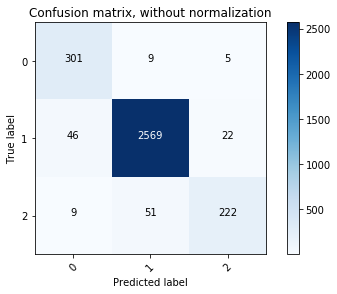

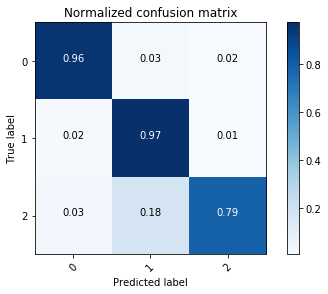

Confusion matrix, without normalization
[[ 21   7   8]
 [  4 289   1]
 [  2  11  19]]
Normalized confusion matrix
[[0.58333333 0.19444444 0.22222222]
 [0.01360544 0.9829932  0.00340136]
 [0.0625     0.34375    0.59375   ]]


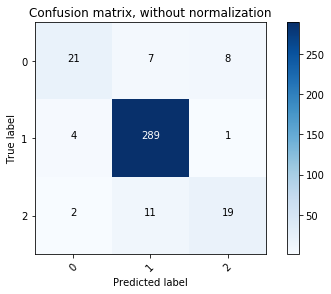

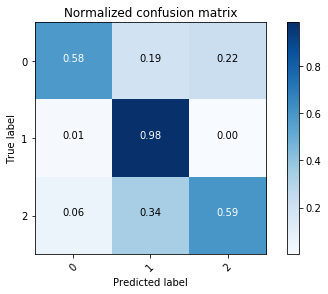

Wall time: 17min 19s


In [17]:
%%time
X_lt_train, y_lt_train, X_lt_test, y_lt_test = divide_to_train_end_test(X_lt_FNS128, y_lt_FNS128, num_categories=3)


model_lt, history_lt, test_scores_lt = run_Xception_with_retrain_on_dataset(X_lt_train, y_lt_train,
                                                                           X_lt_test, y_lt_test,
                                                                           categories_count=3,
                                                                           patience=7)

In [18]:
print("left_top result accuracy:", test_scores_lt[1])

left_top result accuracy: 0.9088397786762175


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 4, 4, 2048)        20861480  
_________________________________________________________________
flatten_7 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 98307     
Total params: 20,959,787
Trainable params: 20,905,259
Non-trainable params: 54,528
_________________________________________________________________
None
Train on 3234 samples, validate on 362 samples
Epoch 1/300
3234/3234 [==============================] - 62s 19ms/step - loss: 0.5401 - acc: 0.8562 - val_loss: 0.6847 - val_acc: 0.8232
Epoch 2/300
3234/3234 [==============================] - 44s 14ms/st

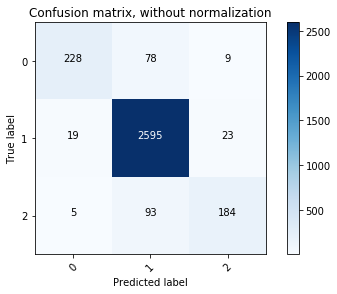

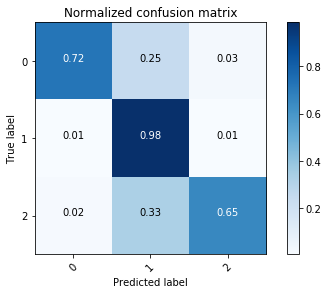

Confusion matrix, without normalization
[[ 12  13  11]
 [  6 283   5]
 [  1  11  20]]
Normalized confusion matrix
[[0.33333333 0.36111111 0.30555556]
 [0.02040816 0.96258503 0.0170068 ]
 [0.03125    0.34375    0.625     ]]


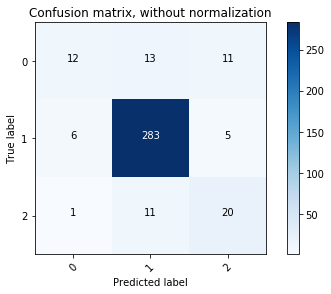

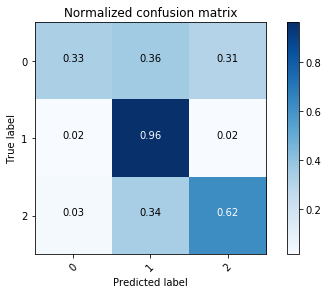

Wall time: 9min 2s


In [22]:
%%time
X_rt_train, y_rt_train, X_rt_test, y_rt_test = divide_to_train_end_test(X_rt_FNS128, y_rt_FNS128, num_categories=3)


model_rt, history_rt, test_scores_rt = run_Xception_with_retrain_on_dataset(X_rt_train, y_rt_train,
                                                                           X_rt_test, y_rt_test,
                                                                           categories_count=3,
                                                                           patience=7)

In [23]:
print("right_top result accuracy:", test_scores_rt[1])

right_top result accuracy: 0.8674033155757419


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 4, 4, 2048)        20861480  
_________________________________________________________________
flatten_8 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 98307     
Total params: 20,959,787
Trainable params: 20,905,259
Non-trainable params: 54,528
_________________________________________________________________
None
Train on 3234 samples, validate on 362 samples
Epoch 1/300
3234/3234 [==============================] - 73s 23ms/step - loss: 0.5598 - acc: 0.8336 - val_loss: 0.9569 - val_acc: 0.7845
Epoch 2/300
3234/3234 [==============================] - 43s 13ms/st

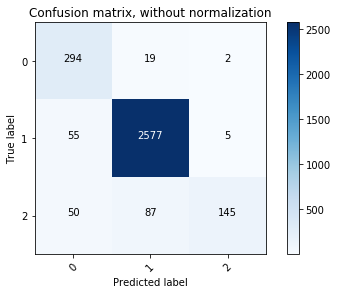

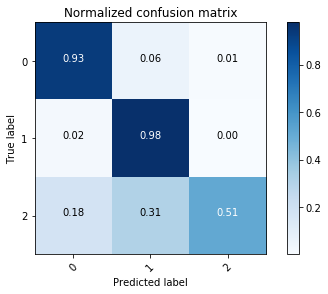

Confusion matrix, without normalization
[[ 27   8   1]
 [ 16 278   0]
 [  8  13  11]]
Normalized confusion matrix
[[0.75       0.22222222 0.02777778]
 [0.05442177 0.94557823 0.        ]
 [0.25       0.40625    0.34375   ]]


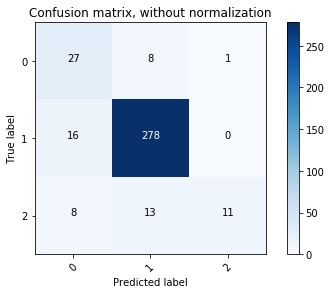

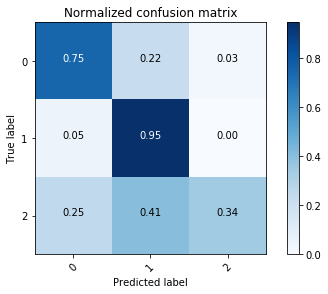

Wall time: 15min 11s


In [24]:
%%time
X_lb_train, y_lb_train, X_lb_test, y_lb_test = divide_to_train_end_test(X_lb_FNS128, y_lb_FNS128, num_categories=3)


model_lb, history_lb, test_scores_lb = run_Xception_with_retrain_on_dataset(X_lb_train, y_lb_train,
                                                                           X_lb_test, y_lb_test,
                                                                           categories_count=3,
                                                                           patience=7)

In [25]:
print("left_bottom result accuracy:", test_scores_lb[1])

left_bottom result accuracy: 0.8701657459386805


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 4, 4, 2048)        20861480  
_________________________________________________________________
flatten_9 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 98307     
Total params: 20,959,787
Trainable params: 20,905,259
Non-trainable params: 54,528
_________________________________________________________________
None
Train on 3234 samples, validate on 362 samples
Epoch 1/300
3234/3234 [==============================] - 76s 23ms/step - loss: 0.7210 - acc: 0.8231 - val_loss: 0.4661 - val_acc: 0.8591
Epoch 2/300
3234/3234 [==============================] - 45s 14ms/st

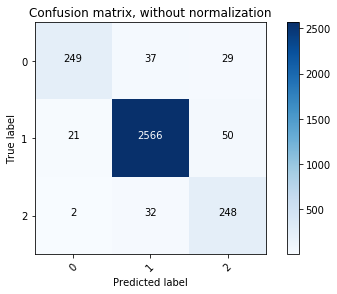

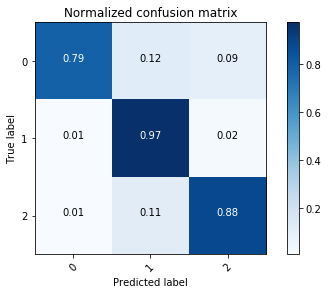

Confusion matrix, without normalization
[[ 15  15   6]
 [  0 279  15]
 [  4   3  25]]
Normalized confusion matrix
[[0.41666667 0.41666667 0.16666667]
 [0.         0.94897959 0.05102041]
 [0.125      0.09375    0.78125   ]]


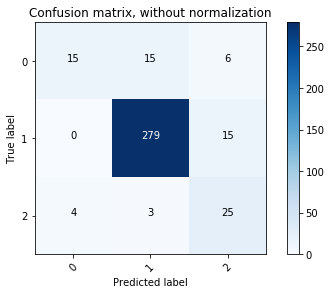

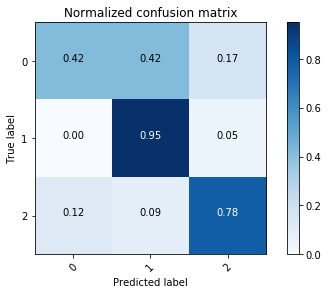

Wall time: 16min 33s


In [28]:
%%time
X_rb_train, y_rb_train, X_rb_test, y_rb_test = divide_to_train_end_test(X_rb_FNS128, y_rb_FNS128, num_categories=3)


model_rb, history_rb, test_scores_rb = run_Xception_with_retrain_on_dataset(X_rb_train, y_rb_train,
                                                                           X_rb_test, y_rb_test,
                                                                           categories_count=3,
                                                                           patience=7)

In [29]:
print("right_bottom result accuracy:", test_scores_rb[1])

right_bottom result accuracy: 0.8812154696132597


## Validation accuracy results

In [30]:
print("center result accuracy: %.4f" % test_scores_ct[1])
print("left_top result accuracy: %.4f" % test_scores_lt[1])
print("right_top result accuracy: %.4f" % test_scores_rt[1])
print("left_bottom result accuracy: %.4f" % test_scores_lb[1])
print("right_bottom result accuracy: %.4f" % test_scores_rb[1])

center result accuracy: 0.9061
left_top result accuracy: 0.9088
right_top result accuracy: 0.8674
left_bottom result accuracy: 0.8702
right_bottom result accuracy: 0.8812


In [31]:
predict_result_ct_train = model_ct.predict(X_ct_train)
predict_result_ct_test = model_ct.predict(X_ct_test)

predict_result_lt_train = model_lt.predict(X_lt_train)
predict_result_lt_test = model_lt.predict(X_lt_test)

predict_result_rt_train = model_lt.predict(X_rt_train)
predict_result_rt_test = model_lt.predict(X_rt_test)

predict_result_lb_train = model_lt.predict(X_lb_train)
predict_result_lb_test = model_lt.predict(X_lb_test)

predict_result_rb_train = model_lt.predict(X_rb_train)
predict_result_rb_test = model_lt.predict(X_rb_test)

In [32]:
predict_un_train = np.concatenate((predict_result_ct_train,
                                  predict_result_lt_train,
                                  predict_result_rt_train,
                                  predict_result_lb_train,
                                  predict_result_rb_train), axis=1)
print(predict_un_train.shape)

(3234, 15)


In [33]:
predict_un_test = np.concatenate((predict_result_ct_test,
                                  predict_result_lt_test,
                                  predict_result_rt_test,
                                  predict_result_lb_test,
                                  predict_result_rb_test), axis=1)
print(predict_un_test.shape)

(362, 15)


In [34]:
# than write this arrays into file
file_path_un_train = "./un_train_France_ByShape128.npy"
np.save(file_path_un_train, predict_un_train)

file_path_un_test = "./un_test_France_ByShape128.npy"
np.save(file_path_un_test, predict_un_test)

file_path_y_train = "./y_train_France_ByShape128.npy"
np.save(file_path_y_train, y_ct_train)

file_path_y_test = "./y_test_France_ByShape128.npy"
np.save(file_path_y_test, y_ct_test)

In [35]:
#np.load(file_path_un_train)

test accuracy:  0.9309

Confusion matrix, without normalization
[[ 299   15    1]
 [  10 2620    7]
 [   2   21  259]]
Normalized confusion matrix
[[0.94920635 0.04761905 0.0031746 ]
 [0.00379219 0.99355328 0.00265453]
 [0.0070922  0.07446809 0.91843972]]


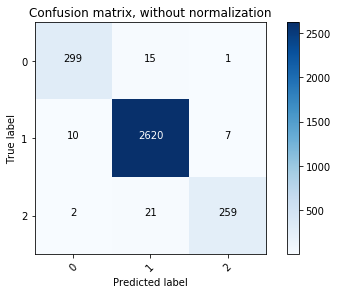

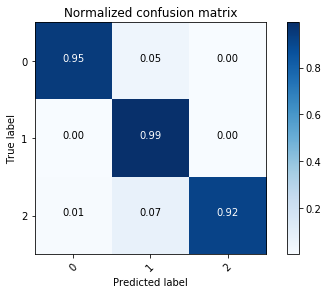

Confusion matrix, without normalization
[[ 24   8   4]
 [  3 291   0]
 [  1   7  24]]
Normalized confusion matrix
[[0.66666667 0.22222222 0.11111111]
 [0.01020408 0.98979592 0.        ]
 [0.03125    0.21875    0.75      ]]


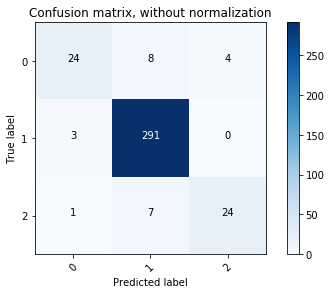

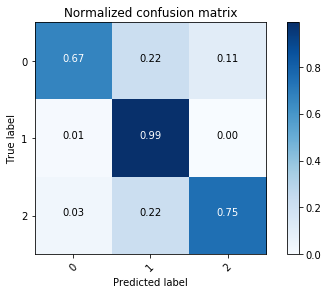

In [36]:
#let's try KNN first
categories_count = 3

knn_uniform_15 = neighbors.KNeighborsClassifier(n_neighbors=15, weights='uniform')
knn_uniform_15.fit(predict_un_train, one_hot(y_ct_train, categories_count))

acc_knn_uniform_15 = accuracy_score(one_hot(y_ct_test, categories_count), knn_uniform_15.predict(predict_un_test))
print("test accuracy:  %.4f" % acc_knn_uniform_15)
print("")

print_confusion_matrix(knn_uniform_15, predict_un_train, y_ct_train, 
                       predict_un_test, y_ct_test, categories_count=categories_count)

In [37]:
knn_uniform_15_predict_train = knn_uniform_15.predict(predict_un_train)
knn_uniform_15_predict_test = knn_uniform_15.predict(predict_un_test)

file_path_knn_uniform_15_train = "./knn_uniform_15_train_Xception_France_ByShape128.npy"
np.save(file_path_knn_uniform_15_train, knn_uniform_15_predict_train)

file_path_knn_uniform_15_test = "./knn_uniform_15_test_Xception_France_ByShape128.npy"
np.save(file_path_knn_uniform_15_test, knn_uniform_15_predict_test)


test accuracy:  0.9309

Confusion matrix, without normalization
[[ 315    0    0]
 [   0 2637    0]
 [   0    0  282]]
Normalized confusion matrix
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


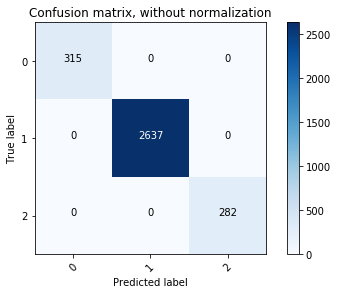

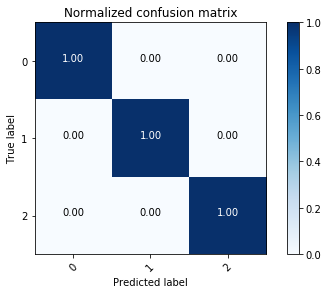

Confusion matrix, without normalization
[[ 23   8   5]
 [  3 291   0]
 [  1   7  24]]
Normalized confusion matrix
[[0.63888889 0.22222222 0.13888889]
 [0.01020408 0.98979592 0.        ]
 [0.03125    0.21875    0.75      ]]


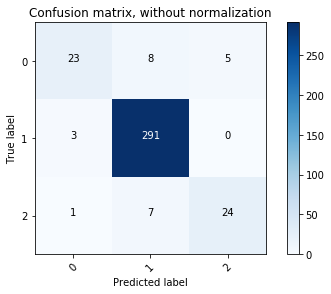

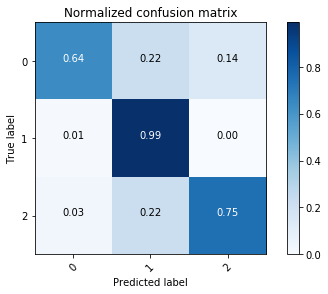

In [38]:
#let's try KNN with another weights
categories_count = 3

knn_distance_15 = neighbors.KNeighborsClassifier(n_neighbors=15, weights='distance')
knn_distance_15.fit(predict_un_train, one_hot(y_ct_train, categories_count))

acc_knn_distance_15 = accuracy_score(one_hot(y_ct_test, categories_count), knn_distance_15.predict(predict_un_test))
print("test accuracy:  %.4f" % acc_knn_distance_15)
print("")

print_confusion_matrix(knn_distance_15, predict_un_train, y_ct_train, 
                       predict_un_test, y_ct_test, categories_count=categories_count)

In [39]:
knn_distance_15_predict_train = knn_distance_15.predict(predict_un_train)
knn_distance_15_predict_test = knn_distance_15.predict(predict_un_test)

file_path_knn_distance_15_train = "./knn_distance_15_train_Xception_France_ByShape128.npy"
np.save(file_path_knn_distance_15_train, knn_distance_15_predict_train)

file_path_knn_distance_15_test = "./knn_distance_15_test_Xception_France_ByShape128.npy"
np.save(file_path_knn_distance_15_test, knn_distance_15_predict_test)


In [40]:
# than SVM
svm = SVC(kernel='rbf')
svm.fit(predict_un_train, y_ct_train)

acc_svm = accuracy_score(y_ct_test, svm.predict(predict_un_test))
print("test accuracy:  %.4f" % acc_svm)
print("")

#print_confusion_matrix(svm, predict_un_train, y_ct_train, 
#                       predict_un_test, y_ct_test, categories_count=categories_count)

test accuracy:  0.9227



In [41]:
svm_predict_train = svm.predict(predict_un_train)
svm_predict_test = svm.predict(predict_un_test)

file_path_svm_train = "./svm_train_Xception_France_ByShape128.npy"
np.save(file_path_svm_train, svm_predict_train)

file_path_svm_test = "./svm_test_Xception_France_ByShape128.npy"
np.save(file_path_svm_test, svm_predict_test)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 512)               8192      
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 3)                 771       
Total params: 140,291
Trainable params: 140,291
Non-trainable params: 0
_________________________________________________________________
None
Train on 3234 samples, validate on 362 samples
Epoch 1/300
3234/3234 [==============================] - 34s 10ms/step - loss: 0.096

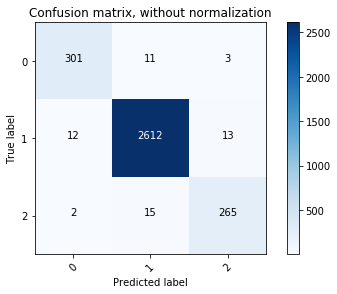

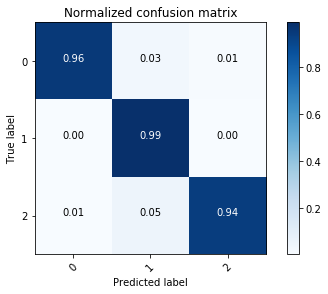

Confusion matrix, without normalization
[[ 21   7   8]
 [  7 287   0]
 [  1   7  24]]
Normalized confusion matrix
[[0.58333333 0.19444444 0.22222222]
 [0.02380952 0.97619048 0.        ]
 [0.03125    0.21875    0.75      ]]


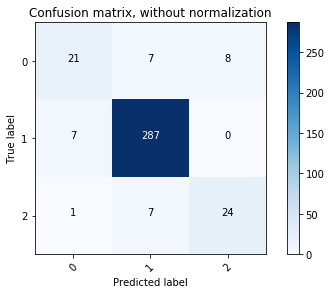

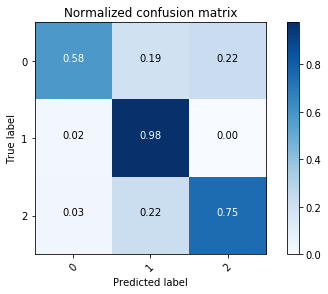

Wall time: 1min 45s


In [42]:
%%time
# and also multilayer neuron net
categories_count = 3

meta_net = Sequential()
meta_net.add(Dense(512, input_shape=predict_un_train[0].shape))
meta_net.add(Dropout(0.5))
meta_net.add(Dense(256))
meta_net.add(Dropout(0.5))
meta_net.add(Dense(categories_count, activation='softmax'))
meta_net.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(meta_net.summary())
    
callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=7, verbose=0, mode='auto')
history_callback = meta_net.fit(predict_un_train, one_hot(y_ct_train, categories_count), 
                            validation_data=(predict_un_test, one_hot(y_ct_test, categories_count)),
                            epochs=300, batch_size=10, callbacks=[callback])

test_scores = meta_net.evaluate(predict_un_test, one_hot(y_ct_test, categories_count), verbose=0)
    
print_confusion_matrix(meta_net, predict_un_train, y_ct_train, predict_un_test, y_ct_test, categories_count)

In [43]:
print("test accuracy:  %.4f" % test_scores[1])
print("best test accuracy: %.4f" % max(history_callback.history['val_acc']))

test accuracy:  0.9199
best test accuracy: 0.9282


In [44]:
meta_net_predict_train = meta_net.predict(predict_un_train)
meta_net_predict_test = meta_net.predict(predict_un_test)

file_path_meta_net_train = "./meta_net_train_Xception_France_ByShape128.npy"
np.save(file_path_meta_net_train, meta_net_predict_train)

file_path_meta_net_test = "./meta_net_test_Xception_ByShape128.npy"
np.save(file_path_meta_net_test, meta_net_predict_test)
